# An example of the Nonlinear inference.

This notebook briefly shows an inference examples for non-linear model with GPinv

*Keisuke Fujii 3rd Oct. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=figs/abel_inversion.png width=240pt>

The local emission intensity $g$ is a function of the radius $r$.
The observed emission intensity $\mathbf{Y}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} g(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $g$ into $n$ discrete points $\mathbf{g}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{g} + \mathbf{e}
$$

## Non-linear model and transform

To make sure $g(r)$ is positive, we define new function $f$,
$$
g(r) = \exp(f(r))
$$
Here, we assume $f(r)$ follows the Gaussian Process with kernel $\mathrm{K}$.
This transformation makes the problem non-linear.

In this notebook, we infer $\mathbf{g}$ by 
1. Stochastic approximation of the variational Gaussian process.
2. Markov Chain Monte-Carlo (MCMC) method.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
# In ../testing/ dir, we prepared a small script for generating the above matrix A
sys.path.append('../testing/')
import make_LosMatrix
# Import GPinv
import GPinv

# graphic thing
import seaborn as sns
sns.set_context('poster')
sns.set_style('ticks')

## Synthetic signals

Here, we make a synthetic measurement.
The synthetic signal $\mathrm{y}$ is simulated from the grand truth solution $g_true$ and random gaussian noise.

In [2]:
n = 30
N = 40
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

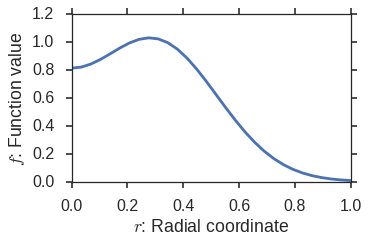

In [3]:
# plotting the latent function
plt.figure(figsize=(5,3))
plt.plot(r, f)
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$f$: Function value')

### Prepare the synthetic signal.

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix.make_LosMatrix(r, z)

In [5]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * np.random.randn(N)

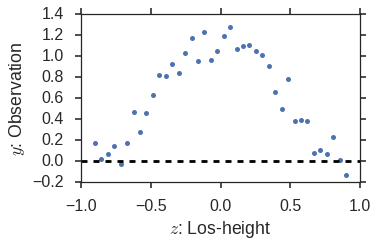

In [6]:
plt.figure(figsize=(5,3))
plt.plot(z, y, 'o', [-1,1],[0,0], '--k', ms=5)
plt.xlabel('$z$: Los-height')
plt.ylabel('$y$: Observation')

# Inference

In order to carry out an inference, a custom **likelihood**, which calculates $p(\mathbf{Y}|\mathbf{f})$ with given $\mathbf{f}$, must be prepared according to the problem.

The method to be implemented is **logp(f,Y)** method, that calculates log-likelihood for data **Y** with given **f**

In [7]:
class AbelLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self, Amat):
        GPinv.likelihoods.Likelihood.__init__(self)
        self.Amat = GPinv.param.DataHolder(Amat)
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)

    def logp(self, F, Y):
        N = tf.shape(F)[0]
        Amat = tf.tile(tf.expand_dims(self.Amat,0), [N, 1,1])
        Af = tf.batch_matmul(Amat, tf.exp(F))
        Y = tf.tile(tf.expand_dims(Y, 0), [N,1,1])
        return GPinv.densities.gaussian(Af, Y, self.variance)

## Variational inference by StVGP

In StVGP, we evaluate the posterior $p(\mathbf{f}|\mathbf{y},\theta)$ by approximating as a multivariate Gaussian distribution.

The hyperparameters are obtained at the maximum of the evidence lower bound (ELBO) $p(\mathbf{y}|\theta)$.

### Kernel

The statistical property is interpreted in Gaussian Process kernel.
In our example, since $f$ is a cylindrically symmetric function, we adopt **RBF_csym** kernel.

### MeanFunction

To make $f$ scale invariant, we added the constant mean_function to $f$.

In [8]:
model_stvgp = GPinv.stvgp.StVGP(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = GPinv.kernels.RBF_csym(1,1),
                           mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                           likelihood=AbelLikelihood(A))

In [9]:
from IPython import display

logf = []
def logger(x):
    if (logger.i % 10) == 0:
        obj = -model_stvgp._objective(x)[0]
        logf.append(obj)
        # display
        if (logger.i % 100) ==0:
            plt.clf()
            plt.plot(logf, '--ko', markersize=3, linewidth=1)
            plt.ylabel('ELBO')
            plt.xlabel('iteration')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    logger.i+=1
logger.i = 1

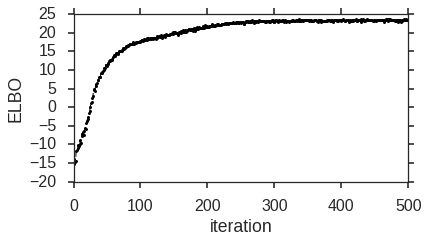

In [10]:
plt.figure(figsize=(6,3))
# Rough optimization by scipy.minimize
model_stvgp.optimize()
# Final optimization by tf.train
trainer = tf.train.AdamOptimizer(learning_rate=0.002)
_= model_stvgp.optimize(trainer, maxiter=5000, callback=logger)

display.clear_output(wait=True)

# MCMC

MCMC is fully Bayesian inference.
The hyperparameters are numerically marginalized out.

In [11]:
model_gpmc = GPinv.gpmc.GPMC(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = GPinv.kernels.RBF_csym(1,1),
                           mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                           likelihood=AbelLikelihood(A))

In [12]:
samples = model_gpmc.sample(300, thin=3, burn=500, verbose=True, epsilon=0.01, Lmax=15)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  90.0 %
Iteration:  400 	 Acc Rate:  92.0 %
Iteration:  500 	 Acc Rate:  93.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  93.0 %
Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  95.0 %
Iteration:  600 	 Acc Rate:  95.0 %
Iteration:  700 	 Acc Rate:  94.0 %
Iteration:  800 	 Acc Rate:  97.0 %
Iteration:  900 	 Acc Rate:  98.0 %


# Result

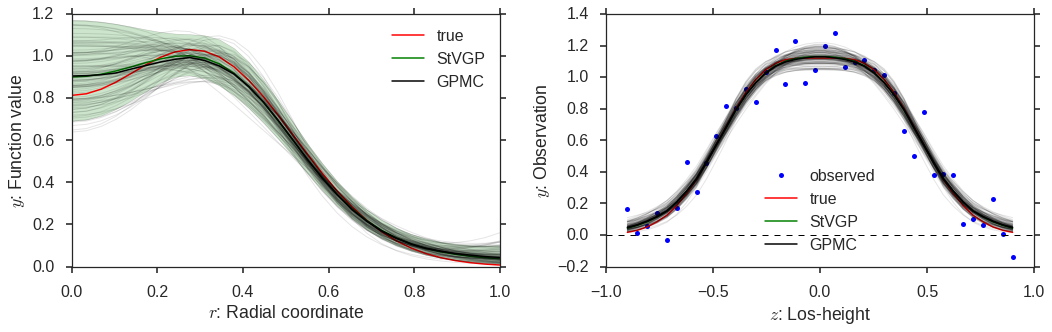

In [13]:
r_new = np.linspace(0.,1., 30)
plt.figure(figsize=(15,5))

# --- observed and grand truth ---
plt.subplot(1,2,1)
plt.plot(r, f, '-r', label='true',lw=1.5)
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$y$: Function value')
plt.subplot(1,2,2)
plt.plot(z, y, 'bo',lw=2, label='observed',ms=5)
plt.plot(z, np.dot(A, f), 'r', label='true',lw=1.5)
plt.plot([-1,1],[0,0],'--k', lw=1)
plt.xlabel('$z$: Los-height')
plt.ylabel('$y$: Observation')

# --- StVGP ---
plt.subplot(1,2,1)
f_pred, f_var = model_stvgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='StVGP',lw=1.5)
plt.subplot(1,2,2)
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'g', label='StVGP',lw=1.5)

# --- GPMC ---
f_mean = []
y_mean = []
for i in range(0,len(samples),3):
    s = samples[i]
    plt.subplot(1,2,1)
    model_gpmc.set_state(s)
    f_pred, f_var = model_gpmc.predict_f(r_new.reshape(-1,1))
    f_mean.append(f_pred)
    plt.plot(r_new, np.exp(f_pred.flatten()), 'k',lw=1, alpha=0.1)
    plt.subplot(1,2,2)
    plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'k',lw=1, alpha=0.1)
    y_mean.append(np.dot(A, np.exp(f_pred.flatten())))
plt.subplot(1,2,1)
plt.plot(r_new, np.exp(np.median(f_mean,axis=0)),'k', lw=1.5, label='GPMC',)
plt.subplot(1,2,2)
plt.plot(z, np.median(y_mean,axis=0),'k', label='GPMC', lw=1.5)
# --- legend ----
plt.subplot(1,2,1)
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.legend(loc='best')
plt.tight_layout()
